In [28]:
# from this result, Akima1D looks the best
import numpy as np
from scipy.interpolate import Akima1DInterpolator, PchipInterpolator, CubicSpline
# C1 smooth splines
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from neurodata import *

# half-octave using equal temperament tuning, a reasonable guess
freqs = [3]
for i in range(8):
    freqs.append(freqs[-1] * 2**(1/2))
freqs = [round(i, 5) for i in freqs]

# stretch 8 values into 15
new_freqs = [3]
for i in range(15):
    new_freqs.append(new_freqs[-1] * 2**(1/2 * 8/15))
new_freqs = [round(i, 5) for i in new_freqs]
freqs, new_freqs

([3, 4.24264, 6.0, 8.48528, 12.0, 16.97056, 24.0, 33.94113, 48.0],
 [3,
  3.60908,
  4.34181,
  5.2233,
  6.28376,
  7.55953,
  9.0943,
  10.94067,
  13.1619,
  15.83409,
  19.04881,
  22.9162,
  27.56876,
  33.16591,
  39.89942,
  48.0])

In [29]:
import sys
sys.path.append('..')
from should_be_stdlib import *
points = np.array([3,48])
(resample_log(points, 9), resample_log(points, 16))

(array([ 3.        ,  4.24264069,  6.        ,  8.48528137, 12.        ,
        16.97056275, 24.        , 33.9411255 , 48.        ]),
 array([ 3.        ,  3.60907511,  4.34180771,  5.22330338,  6.28376474,
         7.5595263 ,  9.0942994 , 10.94066986, 13.16189976, 15.83409493,
        19.04881262, 22.91619849, 27.56876052, 33.16590912, 39.89941901,
        48.        ]))

In [30]:
record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons].reset_index().drop(columns='index')
coords = get_coords(record).loc[sig_neurons]

In [31]:
response = tuning_curves.loc[5]

In [32]:
tuning_curves.columns = [round(i, 1) for i in freqs]
tuning_curves

,3.0,4.2,6.0,8.5,12.0,17.0,24.0,33.9,48.0
0,16.456894,13.668329,31.899306,20.666700,28.913652,13.067111,23.465900,17.077923,24.550303
1,19.666185,20.053940,20.810128,23.999068,19.145863,53.980129,12.112991,51.793921,28.617633
2,22.065571,23.093488,26.505702,26.974120,31.646305,19.263112,20.394083,16.020856,24.291556
3,23.119366,20.392199,22.237800,28.375755,25.468112,25.940932,27.782711,26.228711,47.501961
4,16.372349,15.075036,30.518361,30.283052,25.560817,22.221640,22.428353,27.859761,24.090648
...,...,...,...,...,...,...,...,...,...
71,21.538996,14.505208,79.973022,39.312146,36.783433,34.835992,18.828313,17.153820,56.913355
72,19.843449,15.438443,27.576296,25.962726,32.754157,19.030208,19.374759,19.185503,24.119722
73,23.776134,21.958446,39.174110,28.325787,19.439458,25.816882,25.272167,26.436808,27.578304
74,21.905144,20.097343,26.885299,27.243738,30.921845,21.296552,30.338429,24.899017,20.089453


In [33]:
resampled_tuning_curves = pd.DataFrame(tuning_curves.apply(lambda response: Akima1DInterpolator(freqs, response, method="makima")(new_freqs) , axis=1).to_list() , columns = range(16))
resampled_tuning_curves.columns = [round(i, 1) for i in new_freqs]
resampled_tuning_curves

,3.0,3.6,4.3,5.2,6.3,7.6,9.1,10.9,13.2,15.8,19.0,22.9,27.6,33.2,39.9,48.0
0,16.456894,13.386903,14.241199,25.176446,31.539635,24.015156,21.664837,27.733211,26.075721,14.932476,15.453645,23.010960,21.232582,17.190903,18.695779,24.550303
1,19.666185,19.840688,20.087345,20.425777,21.023481,22.783443,23.997636,20.397992,23.889557,49.052871,45.342355,14.347810,23.870115,50.444558,49.809990,28.617633
2,22.065571,22.414613,23.225317,25.095342,26.715001,26.801150,27.604955,30.739340,30.019475,21.070530,19.405530,20.527198,18.803810,16.194654,17.629602,24.291556
3,23.119366,21.303229,20.403799,21.063979,22.841911,26.785256,28.193448,26.116570,25.504507,25.735888,26.462600,27.534032,27.615674,26.254726,31.578951,47.501961
4,16.372349,14.379722,15.591822,24.712905,30.771663,31.016035,29.484788,26.786906,24.524932,22.618539,21.932779,22.156984,24.246944,27.610572,27.655233,24.090648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,21.538996,12.356102,16.590011,56.295401,78.370247,52.218313,38.760200,37.348634,36.384169,35.540716,31.250492,20.809338,15.684859,16.599499,28.642434,56.913355
72,19.843449,16.181591,15.825230,22.940395,27.695072,26.270266,26.970590,31.579391,30.775811,20.828678,19.111818,19.362034,19.292680,19.180220,20.446969,24.119722
73,23.776134,21.381866,22.509401,33.083331,38.698192,32.618263,26.384493,20.595919,20.495884,25.029319,25.641747,25.223822,25.692074,26.361495,26.978723,27.578304
74,21.905144,20.257182,20.319081,24.231970,27.064658,27.054813,27.817610,30.195632,29.694481,22.591066,23.340456,29.967702,28.661749,25.226559,22.574574,20.089453


In [34]:
x = freqs
xs = new_freqs
y = response
y_akima = Akima1DInterpolator(x, y, method="akima")(xs)
y_makima = Akima1DInterpolator(x, y, method="makima")(xs)
y_cubic = CubicSpline(x, y)(xs) # wobbly
y_linear = np.interp(xs, x, y) # wobbly
y_nearest = scipy.interpolate.interp1d(x, y, kind='nearest')(xs) # basically data reencoding
y_pchip = PchipInterpolator(x, y)(xs) # wobbly


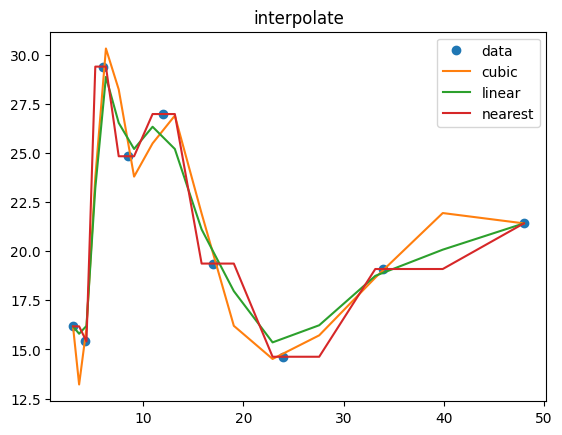

In [37]:
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="data")
# ax.plot(xs, y_akima, label="akima")
# ax.plot(xs, y_makima, label="makima")
ax.plot(xs, y_cubic, label="cubic")
ax.plot(xs, y_linear, label="linear")
# ax.plot(xs, y_pchip, label="pchip")
ax.plot(xs, y_nearest, label="nearest") # technically wrong
ax.legend()
plt.title('interpolate')
fig.show()

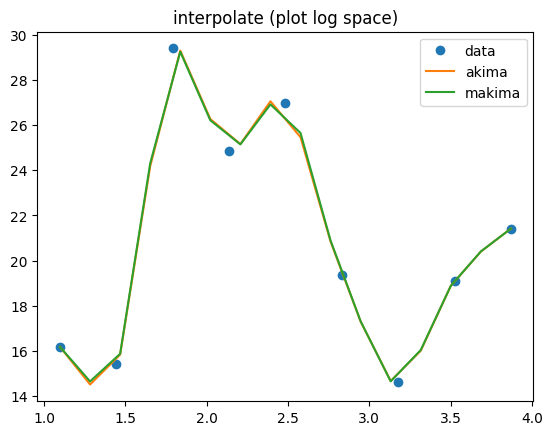

In [7]:
fig, ax = plt.subplots()
ax.plot(np.log(x), y, "o", label="data")
ax.plot(np.log(xs), y_akima, label="akima")
ax.plot(np.log(xs), y_makima, label="makima") # avoids overshooting / div by 0
# ax.plot(np.log(xs), y_cubic, label="cubic")
# ax.plot(np.log(xs), y_linear, label="linear")
# ax.plot(np.log(xs), y_pchip, label="pchip")

# ax.plot(np.log(xs), y_nearest, label="nearest") # technically wrong as different frequencies should elicit different responses
ax.legend()
plt.title('interpolate (plot log space)')
fig.show()